# Notes for decentmon data processing

In [56]:
# adding required packages if not present should not be required since we are using poetry
# !pip install numpy pandas seaborn matplotlib sklearn

# importing them
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from decmon.extractor import *
from decmon.cleaner import *
from decmon.filter import *

#plt.ylim(0, 4000)

In [57]:
# Constants
# FILENAME = "sample_log.txt"
FILENAME = "2022-09-07_12-06-13_output.log"

In [58]:
# idempotent transformation of input file to csv
# file = open(FILENAME, "rt")
# raw_data = file.read()
# raw_data = raw_data.replace(' ', ',') #add commas to read it as a csv
# file.close()
# file = open(FILENAME, "wt")
# file.write(raw_data)
# file.close()

In [59]:
df = pd.read_csv(FILENAME, sep='@')
df.insert(0, 'formula_id', range(0, len(df)))
df.columns = df.columns.str.strip()
df

,formula_id,x,cent_trace_len,decent_trace_len,odecent_trace_len,cent_num_mess,decent_num_mess,odecent_num_mess,cent_size_mess,decent_size_mess,odecent_size_mess,cent_nb_progressions,decent_nb_progressions,odecent_nb_progressions,formula,trace
0,0,1,2,3,2,3,0,0,1.0,0.00,0.00,3,3,3,"Next (Var ""b"")",{a| |c} ; {a| |c} ; {a| | } ; { | | } ; {a| |...
1,1,1,2,3,2,3,0,0,1.0,0.00,0.00,3,3,3,"Next (Var ""c"")",{ | |c} ; { |b| } ; { |b|c} ; {a| |c} ; { | |...
2,2,1,2,3,2,3,0,0,1.0,0.00,0.00,3,3,3,"Next (Var ""a"")",{a|b|c} ; {a| |c} ; { |b| } ; {a|b| } ; {a|b|...
3,3,1,2,3,2,3,0,0,1.0,0.00,0.00,3,3,3,"Next (Var ""c"")",{ | |c} ; {a| | } ; { |b|c} ; { | |c} ; {a|b|...
4,4,1,2,3,2,3,2,0,1.0,1.66,0.00,4,8,4,"Glob (Var ""b"")",{a|b| } ; {a| |c} ; {a|b| } ; { |b|c} ; {a| |...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036,3036,5,20,22,21,57,22,79,1.0,36.46,10.76,962,3207,1153,"Until (Or (Ev (Next (And (Var ""a"", Var ""c"")))...",{ | | } ; { |b|c} ; { | | } ; { |b| } ; {a| |...
3037,3037,5,17,19,18,48,35,51,1.0,46.27,7.88,999,3308,1041,"Until (Or (Var ""c"", Next (Until (Var ""b"", Var...",{ | | } ; {a| |c} ; { |b| } ; {a| |c} ; {a|b|...
3038,3038,5,21,23,22,60,6,21,1.0,0.77,2.76,120,240,143,"Next (Next (Or (Glob (Var ""a""), Ev (And (Var ...",{a| |c} ; { |b|c} ; { |b|c} ; { | |c} ; { | |...
3039,3039,5,23,25,25,66,18,48,1.0,5.61,5.66,240,677,310,"Next (Glob (Until (Until (Var ""b"", Var ""a""), ...",{ | |c} ; {a|b| } ; {a| |c} ; {a| | } ; {a| |...


In [60]:
strategies = {
    "cent" : "orchestration",
    "decent" : "migration",
    "odecent" : "choreography"
}

In [61]:
strategies_df = []
for key, name in strategies.items():
    others = {x: strategies[x] for x in strategies if x != key}
    other_keys = list(others.keys())
    local = rename(df, fr"^{key}_(.*)", r"\1")
    local = exclude_annotate(local, exclude=other_keys, annotate=name)
    strategies_df.append(local)

(cent, decent, odecent) = strategies_df
cent

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy
0,0,1,2,3,1.0,3,"Next (Var ""b"")",{a| |c} ; {a| |c} ; {a| | } ; { | | } ; {a| |...,orchestration
1,1,1,2,3,1.0,3,"Next (Var ""c"")",{ | |c} ; { |b| } ; { |b|c} ; {a| |c} ; { | |...,orchestration
2,2,1,2,3,1.0,3,"Next (Var ""a"")",{a|b|c} ; {a| |c} ; { |b| } ; {a|b| } ; {a|b|...,orchestration
3,3,1,2,3,1.0,3,"Next (Var ""c"")",{ | |c} ; {a| | } ; { |b|c} ; { | |c} ; {a|b|...,orchestration
4,4,1,2,3,1.0,4,"Glob (Var ""b"")",{a|b| } ; {a| |c} ; {a|b| } ; { |b|c} ; {a| |...,orchestration
...,...,...,...,...,...,...,...,...,...
3036,3036,5,20,57,1.0,962,"Until (Or (Ev (Next (And (Var ""a"", Var ""c"")))...",{ | | } ; { |b|c} ; { | | } ; { |b| } ; {a| |...,orchestration
3037,3037,5,17,48,1.0,999,"Until (Or (Var ""c"", Next (Until (Var ""b"", Var...",{ | | } ; {a| |c} ; { |b| } ; {a| |c} ; {a|b|...,orchestration
3038,3038,5,21,60,1.0,120,"Next (Next (Or (Glob (Var ""a""), Ev (And (Var ...",{a| |c} ; { |b|c} ; { |b|c} ; { | |c} ; { | |...,orchestration
3039,3039,5,23,66,1.0,240,"Next (Glob (Until (Until (Var ""b"", Var ""a""), ...",{ | |c} ; {a|b| } ; {a| |c} ; {a| | } ; {a| |...,orchestration


In [62]:
sdf = pd.concat(strategies_df, ignore_index=True)
sdf
gsdf = sdf[sdf['nb_progressions'].isin(sdf.groupby(['formula', 'trace']).min()['nb_progressions'].values)]
#gsdf = sdf.loc[sdf.groupby('formula')['trace'].idxmin()]
#gsdf = sdf.groupby(['formula', 'trace']).min()
gsdf#.apply(print)
#gsdf.describe()
sdf['nb_progressions'].isin(sdf.groupby(['formula', 'trace']).min()['nb_progressions'].values)
sdf.groupby(['formula', 'trace']).min()['nb_progressions'].values

array([94, 34, 91, ..., 12,  8,  8])

In [63]:
metrics = [
    "trace_len",
    "num_mess",
    "size_mess",
    "nb_progressions"
]

In [64]:
metrics_data = []
for metric in metrics:
    metrics_data.append(select_metric(sdf, metric))

merged_metrics = pd.concat(metrics_data)

(trace_length, num_mess, size_mess, nb_progressions) = merged_metrics

merged_metrics.max()

formula_id             3040
strategy      orchestration
value               47303.0
metric            trace_len
dtype: object

In [65]:
def flatten_once(l: list[list]):
    return [item for sublist in l for item in sublist]

In [66]:
map_ops = lambda x: flatten_once(count_all_ops(x['formula']))

f_ops = sdf.copy()
f_ops['newcolumn'] = f_ops.apply(map_ops, axis=1)
ops = flatten_once(all_operators)
f_ops = pd.DataFrame(f_ops['newcolumn'].to_list(), columns=ops)

f_ops

,True,False,Var,And,Or,Neg,Imp,Iff,Xor,Until,Next,Ev,Glob,Previous,Wuntil
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,0,0,9,4,2,3,0,0,0,2,2,1,1,0,0
9119,0,0,9,2,4,3,0,0,0,2,1,1,3,0,0
9120,0,0,3,1,1,0,0,0,0,0,2,1,1,0,0
9121,0,0,3,0,0,1,0,0,0,2,1,0,1,0,0


In [67]:
TRACE_LENGTH = 1001
NODES = 3

In [68]:
def to_int(label: str):
    """
    We categorize observed events
    :param label: observed events
    :return: integer encoding of the event
    """
    if label == 'a':
        return 1
    elif label == 'b':
        return 2
    elif label == 'c':
        return 3
    else:
        return 0

In [69]:
map_trace = lambda x: flatten_once(extract_sampled_events(x['trace']))
trace_label = lambda n: [f"t_{x // NODES}_{x % NODES}" for x in range(n)]

t_events = sdf.copy()
t_events['newcolumn'] = t_events.apply(map_trace, axis=1)
ids = trace_label(TRACE_LENGTH * NODES)
listed_values = t_events['newcolumn'].to_list()
transformed_values = list(map(lambda ls: list(map(to_int, ls)), listed_values))
t_events = pd.DataFrame(transformed_values, columns=ids)


t_events

,t_0_0,t_0_1,t_0_2,t_1_0,t_1_1,t_1_2,t_2_0,t_2_1,t_2_2,t_3_0,...,t_997_2,t_998_0,t_998_1,t_998_2,t_999_0,t_999_1,t_999_2,t_1000_0,t_1000_1,t_1000_2
0,1,0,3,1,0,3,1,0,0,0,...,3,1,0,0,1,0,3,0,2,3
1,0,0,3,0,2,0,0,2,3,1,...,0,1,2,0,0,0,3,0,0,0
2,1,2,3,1,0,3,0,2,0,1,...,3,0,2,0,1,0,0,1,0,3
3,0,0,3,1,0,0,0,2,3,0,...,3,1,2,3,1,2,0,0,2,3
4,1,2,0,1,0,3,1,2,0,0,...,3,1,2,3,0,2,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,0,0,0,0,2,3,0,0,0,0,...,0,0,0,0,0,2,0,1,2,0
9119,0,0,0,1,0,3,0,2,0,1,...,0,1,0,0,1,0,3,1,2,3
9120,1,0,3,0,2,3,0,2,3,0,...,0,0,2,3,1,0,0,1,0,3
9121,0,0,3,1,2,0,1,0,3,1,...,0,0,0,0,1,2,0,0,0,0


In [70]:
expanded_df = f_ops.merge(t_events, left_index=True, right_index=True)
expanded_df = sdf.merge(expanded_df, left_index=True, right_index=True)
expanded_df

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,True,...,t_997_2,t_998_0,t_998_1,t_998_2,t_999_0,t_999_1,t_999_2,t_1000_0,t_1000_1,t_1000_2
0,0,1,2,3,1.00,3,"Next (Var ""b"")",{a| |c} ; {a| |c} ; {a| | } ; { | | } ; {a| |...,orchestration,0,...,3,1,0,0,1,0,3,0,2,3
1,1,1,2,3,1.00,3,"Next (Var ""c"")",{ | |c} ; { |b| } ; { |b|c} ; {a| |c} ; { | |...,orchestration,0,...,0,1,2,0,0,0,3,0,0,0
2,2,1,2,3,1.00,3,"Next (Var ""a"")",{a|b|c} ; {a| |c} ; { |b| } ; {a|b| } ; {a|b|...,orchestration,0,...,3,0,2,0,1,0,0,1,0,3
3,3,1,2,3,1.00,3,"Next (Var ""c"")",{ | |c} ; {a| | } ; { |b|c} ; { | |c} ; {a|b|...,orchestration,0,...,3,1,2,3,1,2,0,0,2,3
4,4,1,2,3,1.00,4,"Glob (Var ""b"")",{a|b| } ; {a| |c} ; {a|b| } ; { |b|c} ; {a| |...,orchestration,0,...,3,1,2,3,0,2,0,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,3036,5,21,79,10.76,1153,"Until (Or (Ev (Next (And (Var ""a"", Var ""c"")))...",{ | | } ; { |b|c} ; { | | } ; { |b| } ; {a| |...,choreography,0,...,0,0,0,0,0,2,0,1,2,0
9119,3037,5,18,51,7.88,1041,"Until (Or (Var ""c"", Next (Until (Var ""b"", Var...",{ | | } ; {a| |c} ; { |b| } ; {a| |c} ; {a|b|...,choreography,0,...,0,1,0,0,1,0,3,1,2,3
9120,3038,5,22,21,2.76,143,"Next (Next (Or (Glob (Var ""a""), Ev (And (Var ...",{a| |c} ; { |b|c} ; { |b|c} ; { | |c} ; { | |...,choreography,0,...,0,0,2,3,1,0,0,1,0,3
9121,3039,5,25,48,5.66,310,"Next (Glob (Until (Until (Var ""b"", Var ""a""), ...",{ | |c} ; {a|b| } ; {a| |c} ; {a| | } ; {a| |...,choreography,0,...,0,0,0,0,1,2,0,0,0,0


## Plotting

In [71]:
def plot(data):
    """
    Plots the data from a single-strategy dataframe
    :param data: single-strategy dataframe
    :return: nothing. Plots the data
    """
    graph = sns.catplot(
        #ax=ax,
        data=data, kind="bar",
        ci="sd", palette="dark", alpha=.8, height=6
    )
    graph.set_axis_labels("", "Count")
    plt.show()

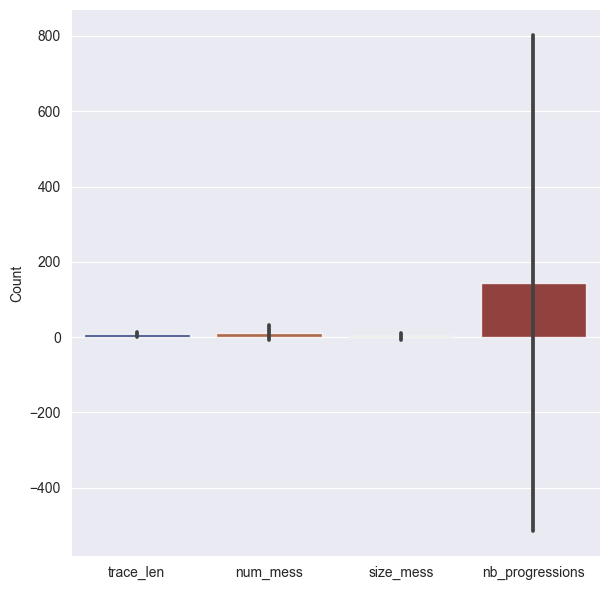

In [72]:
# Plotting
to_plot = sdf.drop(['formula_id', 'x'], axis=1)
plot(to_plot)

In [73]:
merged_metrics.max()

formula_id             3040
strategy      orchestration
value               47303.0
metric            trace_len
dtype: object

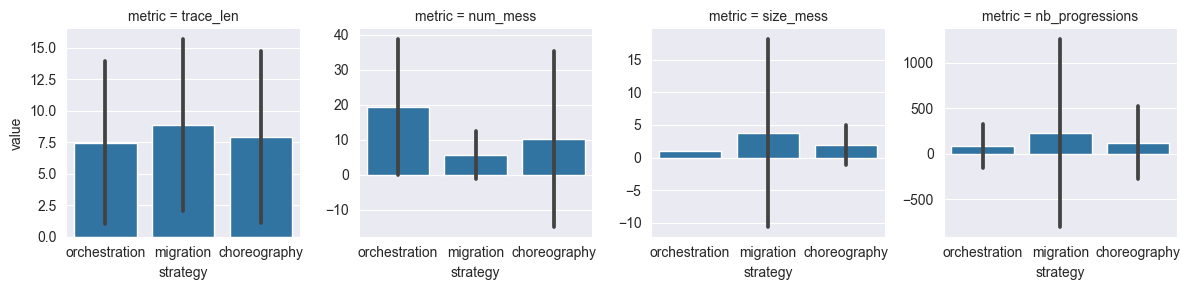

In [74]:
g = sns.FacetGrid(merged_metrics, col="metric", sharey=False)
#plt.ylim(0, 5000)
fig = g.map(sns.barplot, "strategy", "value", order=["orchestration", "migration", "choreography"], ci='sd')
fig.savefig("out.png")
plt.show()

In [75]:
ndf = merged_metrics.copy()
ndf['strategy'] = ndf['strategy'].str.replace("^cent_", "1", regex=True)
ndf['strategy'] = ndf['strategy'].str.replace("^decent_", "2", regex=True)
ndf['strategy'] = ndf['strategy'].str.replace("^odecent_", "3", regex=True)
ndf

,formula_id,strategy,value,metric
0,0,orchestration,2.0,trace_len
1,1,orchestration,2.0,trace_len
2,2,orchestration,2.0,trace_len
3,3,orchestration,2.0,trace_len
4,4,orchestration,2.0,trace_len
...,...,...,...,...
9118,3036,choreography,1153.0,nb_progressions
9119,3037,choreography,1041.0,nb_progressions
9120,3038,choreography,143.0,nb_progressions
9121,3039,choreography,310.0,nb_progressions


In [76]:
expanded_df.strategy = pd.Categorical(expanded_df.strategy)
expanded_df['strategy_id'] = expanded_df.strategy.cat.codes

In [77]:
expanded_df

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,formula,trace,strategy,True,...,t_998_0,t_998_1,t_998_2,t_999_0,t_999_1,t_999_2,t_1000_0,t_1000_1,t_1000_2,strategy_id
0,0,1,2,3,1.00,3,"Next (Var ""b"")",{a| |c} ; {a| |c} ; {a| | } ; { | | } ; {a| |...,orchestration,0,...,1,0,0,1,0,3,0,2,3,2
1,1,1,2,3,1.00,3,"Next (Var ""c"")",{ | |c} ; { |b| } ; { |b|c} ; {a| |c} ; { | |...,orchestration,0,...,1,2,0,0,0,3,0,0,0,2
2,2,1,2,3,1.00,3,"Next (Var ""a"")",{a|b|c} ; {a| |c} ; { |b| } ; {a|b| } ; {a|b|...,orchestration,0,...,0,2,0,1,0,0,1,0,3,2
3,3,1,2,3,1.00,3,"Next (Var ""c"")",{ | |c} ; {a| | } ; { |b|c} ; { | |c} ; {a|b|...,orchestration,0,...,1,2,3,1,2,0,0,2,3,2
4,4,1,2,3,1.00,4,"Glob (Var ""b"")",{a|b| } ; {a| |c} ; {a|b| } ; { |b|c} ; {a| |...,orchestration,0,...,1,2,3,0,2,0,0,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,3036,5,21,79,10.76,1153,"Until (Or (Ev (Next (And (Var ""a"", Var ""c"")))...",{ | | } ; { |b|c} ; { | | } ; { |b| } ; {a| |...,choreography,0,...,0,0,0,0,2,0,1,2,0,0
9119,3037,5,18,51,7.88,1041,"Until (Or (Var ""c"", Next (Until (Var ""b"", Var...",{ | | } ; {a| |c} ; { |b| } ; {a| |c} ; {a|b|...,choreography,0,...,1,0,0,1,0,3,1,2,3,0
9120,3038,5,22,21,2.76,143,"Next (Next (Or (Glob (Var ""a""), Ev (And (Var ...",{a| |c} ; { |b|c} ; { |b|c} ; { | |c} ; { | |...,choreography,0,...,0,2,3,1,0,0,1,0,3,0
9121,3039,5,25,48,5.66,310,"Next (Glob (Until (Until (Var ""b"", Var ""a""), ...",{ | |c} ; {a|b| } ; {a| |c} ; {a| | } ; {a| |...,choreography,0,...,0,0,0,1,2,0,0,0,0,0


In [78]:
cols_to_drop = ['formula', 'trace', 'strategy']
final_df = expanded_df.drop(cols_to_drop, axis=1)

final_df

,formula_id,x,trace_len,num_mess,size_mess,nb_progressions,True,False,Var,And,...,t_998_0,t_998_1,t_998_2,t_999_0,t_999_1,t_999_2,t_1000_0,t_1000_1,t_1000_2,strategy_id
0,0,1,2,3,1.00,3,0,0,1,0,...,1,0,0,1,0,3,0,2,3,2
1,1,1,2,3,1.00,3,0,0,1,0,...,1,2,0,0,0,3,0,0,0,2
2,2,1,2,3,1.00,3,0,0,1,0,...,0,2,0,1,0,0,1,0,3,2
3,3,1,2,3,1.00,3,0,0,1,0,...,1,2,3,1,2,0,0,2,3,2
4,4,1,2,3,1.00,4,0,0,1,0,...,1,2,3,0,2,0,0,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,3036,5,21,79,10.76,1153,0,0,9,4,...,0,0,0,0,2,0,1,2,0,0
9119,3037,5,18,51,7.88,1041,0,0,9,2,...,1,0,0,1,0,3,1,2,3,0
9120,3038,5,22,21,2.76,143,0,0,3,1,...,0,2,3,1,0,0,1,0,3,0
9121,3039,5,25,48,5.66,310,0,0,3,0,...,0,0,0,1,2,0,0,0,0,0


In [79]:
TARGET = 'strategy_id'

In [80]:
y = final_df[TARGET].values
X = final_df.drop(TARGET, axis=1)
X = X.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [81]:
X

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 0.000e+00, 2.000e+00,
        3.000e+00],
       [1.000e+00, 1.000e+00, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 1.000e+00, 2.000e+00, ..., 1.000e+00, 0.000e+00,
        3.000e+00],
       ...,
       [3.038e+03, 5.000e+00, 2.200e+01, ..., 1.000e+00, 0.000e+00,
        3.000e+00],
       [3.039e+03, 5.000e+00, 2.500e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.040e+03, 5.000e+00, 3.900e+01, ..., 0.000e+00, 2.000e+00,
        0.000e+00]])

In [82]:
# K Neighbors Classifier
kn_classifier = KNeighborsClassifier(n_neighbors=3)
kn_classifier.fit(X_train, y_train)

kn_classifier.score(X_test, y_test)

y_pred = kn_classifier.predict(X_test)
kn_classifier.score(X_test, y_test)

0.3905736207526489

In [83]:
from sklearn.preprocessing import StandardScaler

#features = ['sepal length', 'sepal width', 'petal length', 'petal width']

# Separating out the features
x = final_df.loc[:, final_df.columns != 'strategy_id'].values
# Separating out the target
y = final_df.loc[:,['strategy_id']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x

array([[-1.73148133, -1.10565447, -0.90438303, ..., -0.98855611,
         0.98985742,  1.00230453],
       [-1.7303422 , -1.10565447, -0.90438303, ..., -0.98855611,
        -1.01024651, -0.99770077],
       [-1.72920307, -1.10565447, -0.90438303, ...,  1.01157637,
        -1.01024651,  1.00230453],
       ...,
       [ 1.72920307,  2.70215441,  2.06471799, ...,  1.01157637,
        -1.01024651,  1.00230453],
       [ 1.7303422 ,  2.70215441,  2.51008314, ..., -0.98855611,
        -1.01024651, -0.99770077],
       [ 1.73148133,  2.70215441,  4.58845385, ..., -0.98855611,
         0.98985742, -0.99770077]])

In [84]:
from sklearn.decomposition import PCA

principal_components = ['pc 1', 'pc 2']

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = principal_components)

In [85]:
finalDf = pd.concat([principalDf, final_df[['strategy_id']]], axis = 1)
finalDf

,pc 1,pc 2,strategy_id
0,-1.631824,-1.148095,2
1,-2.066657,-1.636810,2
2,-1.948461,3.594380,2
3,-1.893478,0.827668,2
4,-2.383014,3.410735,2
...,...,...,...
9118,7.260189,-0.076900,0
9119,7.086660,-0.119566,0
9120,2.889686,-0.632294,0
9121,3.068694,0.366669,0


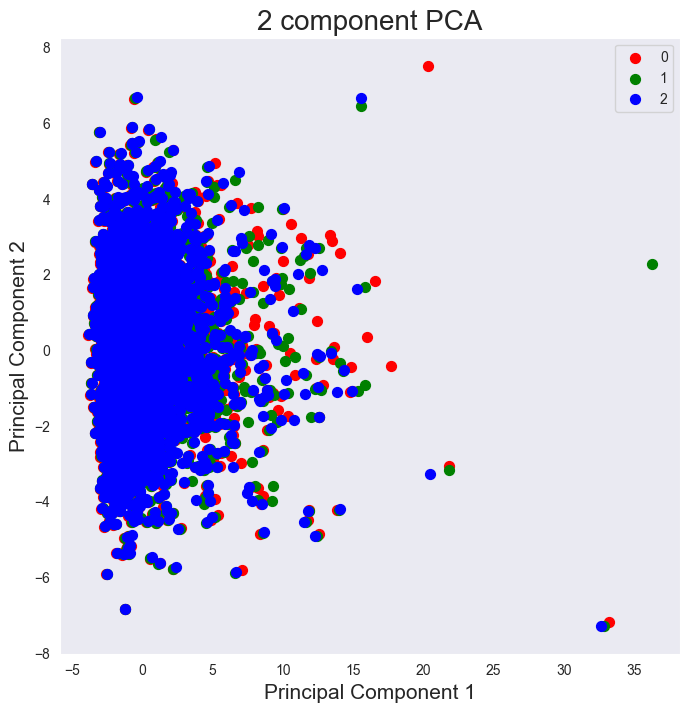

In [86]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['strategy_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc 1']
               , finalDf.loc[indicesToKeep, 'pc 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()